In [3]:
# Import necessary libraries for data handling, plotting, and deep learning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow. keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


In [4]:
# Function to load and preprocess audio data by extracting features (MFCCs)
def load_and_preprocess_data(audio_path, label):
    # Load the audio file and set sample rate to None to keep it original
    audio, sr = librosa.load(audio_path, sr=None)

    # Extract MFCC (Mel-frequency cepstral coefficients) features, often used in audio analysis
    mfccs = librosa. feature.mfcc(y=audio, sr=sr, n_mfcc=13)

    # Transpose MFCCs to shape them correctly for model input
    return mfccs.T, label

# Function to prepare dataset from real and fake audio file paths
def prepare_dataset(real_paths, fake_paths):
    X, y = [], [] # X will hold features, y will hold labels (0 for real, 1 for fake)
    # Load real audio files and label them as 0 (real)
    for path in real_paths:
        features, label = load_and_preprocess_data(path, 0)
        X.append (features)
        y.append(label)

    # Load fake audio files and label them as 1 (fake)
    for path in fake_paths:
        features, label = load_and_preprocess_data(path, 1)
        X.append (features)
        y.append(label)

    # Return features(X) and labels (y) as numpy arrays for model compatibility
    return X,np.array(y)


In [5]:
# Function to apply data augmentation techniques to the dataset
def augment_data(X, y):
    augmented_X, augmented_y = [], []

    # Loop through each feature set and label
    for features, label in zip(X, y):
        augmented_X.append (features) # Original features
        augmented_y.append(label) # Original label

        # Time stretching (simulate by adjusting audio speed before extracting features)
        audio_signal = librosa.effects. time_stretch(features. T[0], rate=0.8)
        augmented_X.append(librosa.feature.mfcc(y=audio_signal, sr=22050, n_mfcc=13).T)
        augmented_y.append (label)

        # Pitch shifting (change pitch slightly for diversity in data)
        audio_signal_shifted = librosa.effects.pitch_shift(features. T[0], sr=22050, n_steps=2)
        augmented_X.append(librosa. feature.mfcc(y=audio_signal_shifted, sr=22050, n_mfcc=13).T)
        augmented_y.append (label)

    # Return augmented features and labels
    return augmented_X, np.array(augmented_y)


In [6]:
# An LSTM, or Long Short-Term Memory network, is a special type of neural network that's great for
# handling sequences of data, like text, speech, or time-series data. Imagine it as a smart memory system
# that remembers important information from the past and forgets unimportant details.

# Here's a simple breakdown:

# Memory Cells: LSTM networks have "memory cells" that can hold information over long time periods.
# Each cell decides what to remember, what to forget, and what new information to add, using special
# structures called "gates.

#"Gates: There are three main gates:

# Forget Gate: Decides what past information to forget.
#Input Gate: Chooses which new information to store.
# Output Gate: Decides what information to send to the next step.

# Learning from Sequences: These gates allow LSTMs to selectively remember or forget information as theyprocess each step of the sequence,
#making them useful for things like language translation,predicting stock prices, or detecting anomalies in sensor data.

def create_model(input_shape) :

    model = Sequential ([
        Input(shape=input_shape),
        Masking(mask_value=0.),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(2, activation='softmax' )
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy' ])

    return model


In [7]:
# Function to train and evaluate the model
def train_and_evaluate(model, X_train, y_train, X_test, y_test, epochs=25, batch_size=32):

    # Train the model and store the training history for plotting
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2, verbose=1)

    # Evaluate the model on test data and print test accuracy
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test accuracy: {test_acc :.4f}")

    # Return the training history to analyze learning progress
    return history


In [8]:
# Function to visualize training and validation accuracy and loss
def plot_training_history(history) :
    plt.figure(figsize=(12, 4))

    # Plot accuracy over epochs
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel ('Epoch')
    plt.ylabel('Accuracy')
    plt. legend ()

    # Plot loss over epochs
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title( 'Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt. show()


In [9]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [10]:
import os

In [11]:
base_path =  "/kaggle/input/ai-real/data"


In [12]:
from tensorflow.keras.preprocessing. sequence import pad_sequences

In [13]:
from tensorflow.keras.layers import Input, Masking

In [17]:
real_paths = [os. path. join(base_path, "real", f) for f in os. listdir(os. path. join(base_path, "real") ) if f. endswith(".wav")]
fake_paths = [os. path. join(base_path, "fake", f) for f in os. listdir(os. path. join(base_path, "fake") ) if f. endswith(".wav")]

In [ ]:
# Prepare and augment the dataset
X, y = prepare_dataset (real_paths, fake_paths)
X_augmented, y_augmented = augment_data(X, y)

In [19]:
# Pad sequences
max_length = max(len(seq) for seq in X_augmented)
X_padded = pad_sequences(X_augmented, maxlen=max_length, dtype='float32', padding='post', truncating='post')


In [20]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_augmented, test_size=0.2, random_state=42)


In [21]:
# Convert labels to categorical
y_train = to_categorical (y_train)
y_test = to_categorical(y_test)

In [22]:
# Create and train the model
model = create_model(input_shape=(X_train. shape[1], X_train. shape[2]))
history = train_and_evaluate(model, X_train, y_train, X_test, y_test)


Epoch 1/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.7078 - loss: 0.5405 - val_accuracy: 0.9123 - val_loss: 0.2377
Epoch 2/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9001 - loss: 0.2415 - val_accuracy: 0.9234 - val_loss: 0.1960
Epoch 3/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9207 - loss: 0.1918 - val_accuracy: 0.9241 - val_loss: 0.1905
Epoch 4/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9254 - loss: 0.1784 - val_accuracy: 0.9463 - val_loss: 0.1422
Epoch 5/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9313 - loss: 0.1751 - val_accuracy: 0.9483 - val_loss: 0.1367
Epoch 6/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9399 - loss: 0.1509 - val_accuracy: 0.9548 - val_loss: 0.1252
Epoch 7/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9445 - loss: 0.1442 - val_accuracy: 0.9300 - val_loss: 0.1621
Epoch 8/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9351 - loss: 0.1596 - val_acc

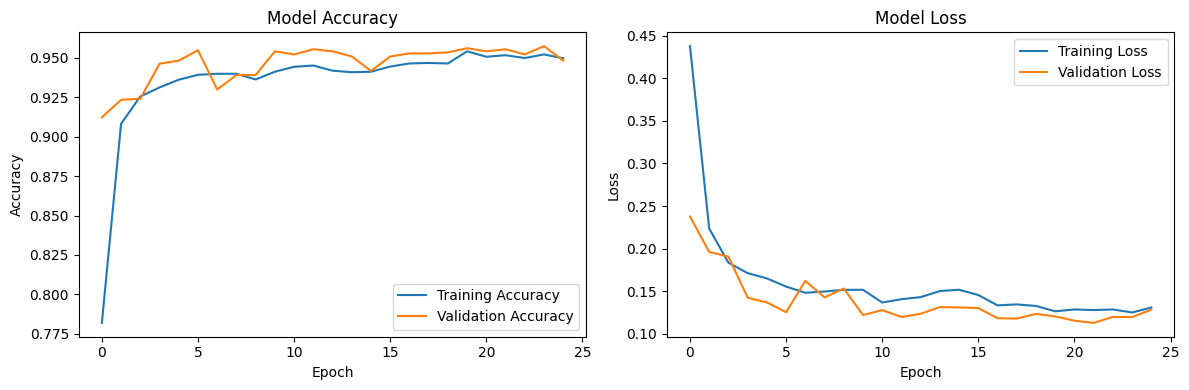

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


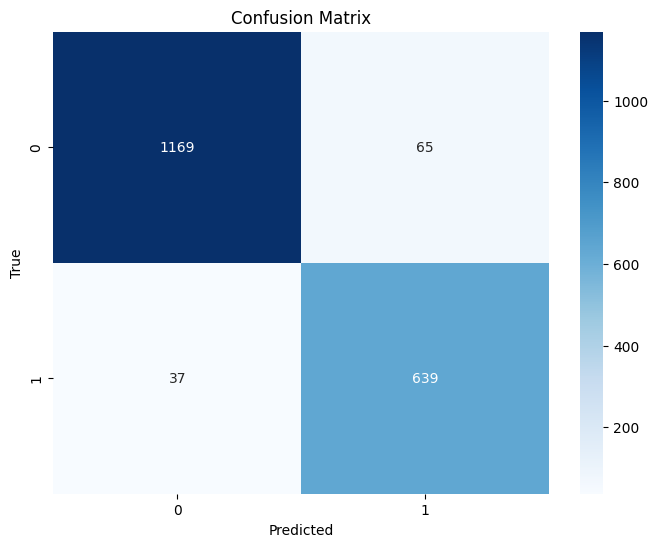

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1234
           1       0.91      0.95      0.93       676

    accuracy                           0.95      1910
   macro avg       0.94      0.95      0.94      1910
weighted avg       0.95      0.95      0.95      1910



In [23]:
# Visualize the results
plot_training_history(history)
y_pred = model.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))



In [24]:
# Optional: Print dataset statistics
print(f"Number of real audio samples: {len(real_paths)}")
print(f"Number of fake audio samples: {len(fake_paths)}")
print(f"Total number of samples: {len(real_paths) + len(fake_paths)}")
print(f"Shape of padded dataset: {X_padded. shape}")
print(f"Maximum sequence length: {max_length}")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test. shape}")


Number of real audio samples: 2000
Number of fake audio samples: 1183
Total number of samples: 3183
Shape of padded dataset: (9549, 969, 13)
Maximum sequence length: 969
Shape of X_train: (7639, 969, 13)
Shape of X_test: (1910, 969, 13)


In [25]:
import librosa
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
def preprocess_audio(audio_path, max_length):
    # Load the audio
    audio, sr = librosa.load(audio_path, sr=None)

    # Extract MFCC features (use same parameters as training)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

    # Transpose the MFCCs to match the input format
    mfccs = mfccs.T

    # Pad the sequence to the max length used during training
    padded_mfccs = pad_sequences([mfccs], maxlen=max_length, dtype='float32', padding='post', truncating='post')

    return padded_mfccs


In [33]:
test_audio_paths = ["/kaggle/input/ai-real/data/fake/file1000.wav","/kaggle/input/ai-real/data/real/file4916.wav"]
for audio_path in test_audio_paths :
    padded_sample = preprocess_audio(audio_path, max_length=X_train.shape [1])
    prediction = model.predict(padded_sample)
    predicted_class = np.argmax(prediction, axis=1) [0]

    if predicted_class == 1:
        print(f"{audio_path}: Fake")
    else :
       print(f"{audio_path}: Real")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
/kaggle/input/ai-real/data/fake/file1000.wav: Fake
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
/kaggle/input/ai-real/data/real/file4916.wav: Real


In [34]:
#model.save("/content/drive/MyDrive/AUDIO/deepfake_audio_model.h5")

model.save('1stm_model.h5')